## 그래프 설정 및 IR, RGB 데이터 불러오기

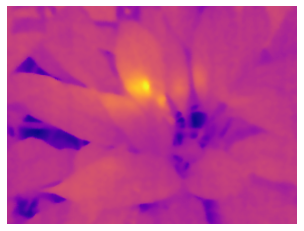

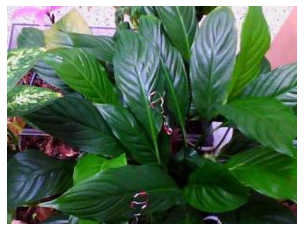

In [1]:
import cv2
import matplotlib.pyplot as plt
import util

plt.rc('font', family='Apple SD Gothic Neo')

WIDTH = 320
HEIGHT = 240

ir = util.load_ir_in_csv('./lily-ir/121.csv')
rgb = cv2.cvtColor(src=cv2.imread('./lily-rgb/FLIR0121- 사진.jpg'),
                   code=cv2.COLOR_BGR2RGB)

util.show_images(ir, rgb)

방법1: K-Means 클러스터링
* Jenks Natural Breaks와 유사한 결과를 보임
* Jenks Natural Breaks가 1D K-Means 클러스터링 알고리즘이기 때문
* TODO: feature에 좌표(row, col) 추가

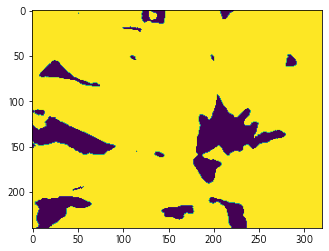

In [2]:
import numpy as np

ir_kmeans = np.float32(ir).reshape(-1)
criteria = (
    cv2.TERM_CRITERIA_EPS, # type
    10, # max_iter
    0.001 # epsilon
    )
compactness, labels, centers = cv2.kmeans(data=ir_kmeans.ravel(),
                                          K=2,
                                          bestLabels=None,
                                          criteria=criteria,
                                          attempts=100,
                                          flags=cv2.KMEANS_RANDOM_CENTERS)

plt.imshow(labels.reshape(HEIGHT, WIDTH))
plt.show()

방법2: 윤곽선(contours) 찾기 및 채우기
* 윤곽선이 잘 찾아지지 않음
* threshold parameter 조정 필요

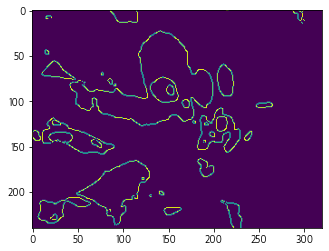

In [3]:
ir = ir.astype(np.uint8)

edges = cv2.Canny(ir,
                  threshold1=0.01,
                  threshold2=0.02)
plt.imshow(edges)
plt.show()

방법3: Jenks Natural Breaks 기법
* 1D에 최적화된 K-Means 클러스터링이라고 알려짐

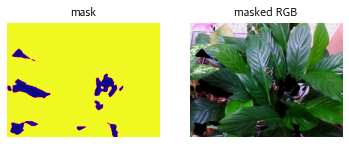

In [4]:
from jenkspy import jenks_breaks
import numpy as np

breaks_ir = jenks_breaks(ir.ravel(), nb_class=2)

mask = cv2.inRange(ir, breaks_ir[1], breaks_ir[2])

fig, axs = plt.subplots(1, 2)
axs[0].imshow(mask, cmap='plasma')
axs[0].axis(False)
axs[0].set_title('mask')

axs[1].imshow(cv2.bitwise_and(src1=cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB),
                              src2=rgb))
axs[1].axis(False)
axs[1].set_title('masked RGB')
plt.show()

방법4: K-Means 클러스터링(좌표 포함)

In [5]:
import numpy as np

ir_with_pos = np.zeros(shape=(HEIGHT, WIDTH))
for row in range(HEIGHT):
    for col in range(WIDTH):
        ir_with_pos[row][col] = np.nd
for row, col in np.ndindex(ir.shape):
    ir_with_pos[row][col] = (row, col, ir[row][col])

# 정규화
ir_with_pos[:,:,0] /= HEIGHT
ir_with_pos[:,:,1] /= WIDTH
#ir_with_pos[:,:,2] /= 


ir_with_pos = np.float32(ir_with_pos).reshape(-1,3)
criteria = (
    cv2.TERM_CRITERIA_EPS, # type
    10, # max_iter
    0.001 # epsilon
    )
compactness, labels, centers = cv2.kmeans(data=ir_with_pos,
                                          K=2,
                                          bestLabels=None,
                                          criteria=criteria,
                                          attempts=100,
                                          flags=cv2.KMEANS_RANDOM_CENTERS)

plt.imshow(labels.reshape(HEIGHT, WIDTH))
plt.show()

AttributeError: module 'numpy' has no attribute 'nd'

excess-green index 계산
* RGB 이미지를 통해 계산한 값으로, segmentation의 성능 평가를 하기 위함

In [ ]:
exg = np.zeros(shape=(HEIGHT, WIDTH))
for row, col, _channel in np.ndindex(rgb.shape):
    sum_channels = rgb[row][col].sum()
    # TODO: 0으로 나누는 예외 사항 처리하기
    if sum_channels == 0:
        r, g, b = 0, 0, 0
    else:
        r, g, b = rgb[row][col] / sum_channels
    exg[row][col] = 2 * g - r - b

common.show_histogram(exg, title='exg histogram')

breaks_exg = jenks_breaks(exg.ravel(), nb_class=2)

leaf = cv2.inRange(exg, breaks_exg[1], breaks_exg[2])

fig, axs = plt.subplots(1, 2)
axs[0].imshow(exg, cmap='plasma')
axs[0].axis(False)
axs[0].set_title('excess-green index')

axs[1].imshow(leaf, cmap="plasma")
axs[1].axis(False)
axs[1].set_title('leaf region')

plt.show()

잎 영역의 온도 구하기

In [ ]:
max_temperature = np.max(ir[mask == 0xFF])
min_temperature = np.min(ir[mask == 0xFF])
mean_temperature = cv2.mean(ir, mask)[0]

print('온도 최대값:', max_temperature)
print('온도 최소값:', min_temperature)
print('온도 평균값:', mean_temperature)